# Семинар 5
Ratio metrics: как тестить зависимые данные

## Типичные метрики отношения

- Средний чек (Average Order Value):
$$\text{AOV} = \frac{\Sigma_{u\in \text{Users}} \text{order amount}_u}{\Sigma_{u\in \text{Users}} \text{orders}_u}$$

- Click-through rate:
$$\text{CTR} = \frac{\Sigma_{u\in \text{Users}} \text{clicks}_u}{\Sigma_{u\in \text{Users}} \text{views}_u}, \; corr(\text{clicks}_u, \text{views}_u) > 0$$

- Средняя длина сессии юзера:
$$\text{AvgLength} = \frac{\Sigma_{u\in \text{Users}} \Sigma_{i=1}^{N_u} \text{session time}_{ui}}{\Sigma_{u\in \text{Users}} \text{N sessions}_u}$$

- Risk Ratio

|   |treat|control|
|---|---|---|
|outcome +| a | b |
|outcome -| c | d |

$p_t = \frac{a}{a+c}$, $p_c = \frac{b}{b+d}$


$$\text{RR} = \frac{p_t}{p_c}$$

Любую такую метрику можно представить как отношение средних:
$$\bar{Y} = \frac{\Sigma_i \Sigma_j Y_{ij}}{\Sigma_i N_i} = 
\frac{\Sigma_i S_i / n}{\Sigma_i N_i / n} = \frac{\bar{S}}{\bar{N}}$$

## Как нам проверять гипотезу $R_c - R_t = 0$?

Попробуем по классике t-тестом

### 1. Стандартный тест Стьюдента

- 2 группы по 1000 человек
- Каждый покупатель совершает от 1 до 5 покупок
- Значения среднего чека рандомное от 1000 до 2000

Применим тест Стьюдента к сгенерированным данным и запомним значение p-value. Повторим эту процедуру 1000 раз и построим эмпирическую функцию распределения p-value. Для корректного критерия распределение p-value должно быть близко к равномерному распределению от 0 до 1.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


def generate_data(sample_size, effect):
    """Генерирует данные со стоимостью покупок.

    Возвращает два списка с данными контрольной и экспериментальной групп.
    Элементы списков - множества со стоимостями покупок пользователей.
    """
    result = []
    for group_effect in [0, effect]:
        n_purchases = np.random.randint(1, 5, sample_size)
        mean_costs = np.random.uniform(1000, 2000, sample_size)
        data = [
            np.random.normal(loc=mean + group_effect, scale=200, size=n)
            for n, mean in zip(n_purchases, mean_costs)
        ]
        result.append(data)
    return result


alpha = 0.05  # допустимая вероятность ошибки I рода
sample_size = 1000  # размер групп

pvalues = []
for _ in range(1000):
    a, b = generate_data(sample_size, 0)
    a_values = np.hstack(a)
    b_values = np.hstack(b)
    pvalue = stats.ttest_ind(a_values, b_values).pvalue
    pvalues.append(pvalue)

In [3]:
print(a[0])
print(b[0])

[2032.32098281 1998.17132331]
[1538.04100545 1353.95874963]


In [4]:
error_rate = np.mean(np.array(pvalues) < alpha)
print(f"Доля ошибок первого рода: {error_rate:0.2f}")

Доля ошибок первого рода: 0.18


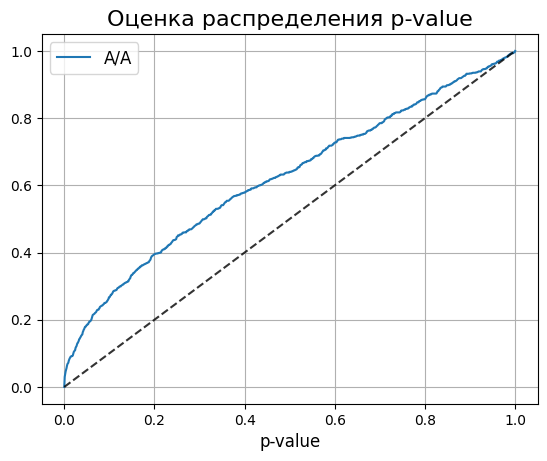

In [5]:
def plot_pvalue_distribution(dict_pvalues):
    """Рисует графики распределения p-value."""
    X = np.linspace(0, 1, 1000)
    for name, pvalues in dict_pvalues.items():
        Y = [np.mean(pvalues < x) for x in X]
        plt.plot(X, Y, label=name)

    plt.plot([0, 1], [0, 1], "--k", alpha=0.8)
    plt.title("Оценка распределения p-value", size=16)
    plt.xlabel("p-value", size=12)
    plt.legend(fontsize=12)
    plt.grid()
    plt.show()


plot_pvalue_distribution({"A/A": pvalues})

Распределение p-value получилось **неравномерным**

Доля ошибок первого рода 0.2, это значительно больше ожидаемых 0.05.

При проверке гипотезы о равенстве метрик отношения тест Стьюдента работает некорректно.

#### Почему?


В нашей выборке были **зависимые данные**: покупки одного клиента зависимы, а тест Стьюдента предполагает независимость данных.

### 2. Среднее средних: наивная поюзерная метрика 

Давайте избавимся от зависимых данных, объединив покупки по клиентам.

Для каждого клиента посчитаем его средний чек и по этим данным проверим гипотезу о равенстве средних.

Доля ошибок первого рода: 0.05


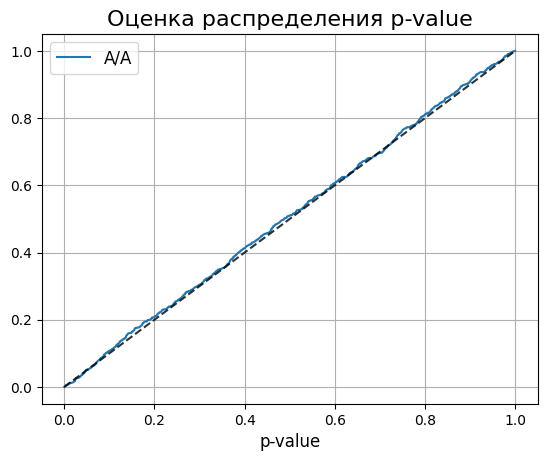

In [6]:
pvalues = []
for _ in range(1000):
    a, b = generate_data(sample_size, 0)
    a_means = [np.mean(x) for x in a]
    b_means = [np.mean(x) for x in b]
    pvalue = stats.ttest_ind(a_means, b_means).pvalue
    pvalues.append(pvalue)


error_rate = np.mean(np.array(pvalues) < alpha)
print(f"Доля ошибок первого рода: {error_rate:0.2f}")
plot_pvalue_distribution({"A/A": pvalues})

Распределение p-value получилось равномерным. Тест Стьюдента работает корректно.

Мы перешли от проверки гипотезы о равенстве метрик отношения к проверке гипотезы о равенстве среднего средних.

#### Можно ли результаты, полученные при проверке одной гипотезы, обобщать на другую гипотезу?

Нельзя! Не соблюдается свойство **сонаправленности**

### 3. Бутстреп

Основная особенность применения бутстрепа для метрик отношения — данные необходимо семплировать по объектам, а не по наблюдениям. 
    
Если объект оказался в определённой группе, то и все его действия будут в этой группе.

In [11]:
def get_percentile_ci(bootstrap_stats, alpha):
    """Строит перцентильный доверительный интервал."""
    left, right = np.quantile(bootstrap_stats, [alpha / 2, 1 - alpha / 2])
    return left, right


def check_bootstrap(a, b, n_iter=1000):
    """Оценивает значимость отличий с помощью бутстрепа.

    Если отличия значимые, то возвращает 1, иначе 0.
    """
    # вычисляем стоимость и количество покупок клиентов
    xy_a = np.array([[sum(values), len(values)] for values in a])
    xy_b = np.array([[sum(values), len(values)] for values in b])
    # генерируем случайные индексы для выбора подмножеств данных
    len_a = len(a)
    len_b = len(b)
    indexes_a = np.random.choice(np.arange(len_a), size=(n_iter, len_a), replace=True)
    indexes_b = np.random.choice(np.arange(len_b), size=(n_iter, len_b), replace=True)

    bootstrap_stats = []
    for idx_a, idx_b in zip(indexes_a, indexes_b):
        bootstrap_xy_a = xy_a[idx_a]
        bootstrap_xy_b = xy_b[idx_b]
        # считаем разницу метрик отношения
        bootstrap_stat = (
            bootstrap_xy_b[:, 0].sum() / bootstrap_xy_b[:, 1].sum()
            - bootstrap_xy_a[:, 0].sum() / bootstrap_xy_a[:, 1].sum()
        )
        bootstrap_stats.append(bootstrap_stat)

    # считаем реальную разность двух групп
    delta_mean = np.sum(xy_b[:, 0]) / np.sum(xy_b[:, 1]) - np.sum(xy_a[:, 0]) / np.sum(
        xy_a[:, 1]
    )
    std_delta_mean = np.std(bootstrap_stats)

    # считаем p-value
    pvalue_delta_mean = 2 * (1 - stats.norm.cdf(np.abs(delta_mean / std_delta_mean)))

    return pvalue_delta_mean


alpha = 0.05  # допустимая вероятность ошибки I рода
sample_size = 1000  # размер групп
n_iter = 1000  # количество итераций бутстрепа
effect = 50

pvalues_aa = []
pvalues_ab = []
for _ in range(1000):
    a, b = generate_data(sample_size, 0)
    pvalues_aa.append(check_bootstrap(a, b))
    a, b = generate_data(sample_size, effect)
    pvalues_ab.append(check_bootstrap(a, b))

error_rate = np.mean(np.array(pvalues_aa) < alpha)
print(f"Доля ошибок первого рода: {error_rate:0.2f}")

Доля ошибок первого рода: 0.05


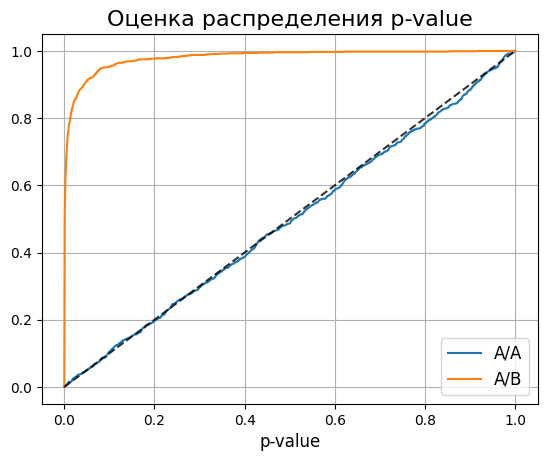

In [12]:
plot_pvalue_distribution({"A/A": pvalues_aa, "A/B": pvalues_ab})

#### Будет ли бутстрап работать корректно? Почему?

Да, будет, потому это непараметрический метод (он не делает предположения о виде распределения)



Мы нашли способ, который корректно проверяет гипотезу о равенстве метрик отношения. 
Однако, этот способ имеет существенный недостаток. Бутстреп является вычислительно трудоёмким подходом. 

Если вам нужно оценивать эксперименты с большими объёмами данных, то применение бутстрепа может занимать часы или даже дни.



### 4. Дельта-метод

$$t=\frac{\mathcal{R}_B-\mathcal{R}_A}{\sqrt{\hat{\sigma^2} \left(\mathcal{R}_A\right)+\hat{\sigma^2}\left(\mathcal{R}_B\right)}}$$
Главные вопросы, на которые нужно найти ответ: 
- Как выглядит дисперсия ratio метрики? 
- Как выглядит распределение T?

Изначально наша метрика имеет вид

$$R = \frac{\bar{X}}{\bar{Y}} \sim \frac{N(...)}{N(...)}$$

Это распределение Коши, которое в общем случае не имеет матожа и дисперсии

<img src="pics/normal_distr.jpg" width="500" />

Ранее мы говорили, что тест Стьюдента не работает для метрик отношения из-за зависимых данных. 


Воспользуемся формулами, выведенными на лекции:

\begin{aligned}
&E(R) = \frac {\mu_x} {\mu_y}  \\ 
&V(R) = \frac{1}{N \mu_y^2}V(X) - 2\frac{\mu_x}{N \mu_y^3} cov
(X, Y) + \frac{\mu_x^2}{N\mu_y^4}V(Y) \\

\end{aligned}

Тогда можем построить t-статистику:
$$
t=\frac{\mathcal{R}_B-\mathcal{R}_A}{\sqrt{\mathbb{V}\left(\mathcal{R}_A\right)+\mathbb{V}\left(\mathcal{R}_B\right)}} \xrightarrow{N \rightarrow \inf } \mathcal{N}(0,1)
$$

In [6]:
def check_delta_method(a, b):
    """Проверка гипотезы с помощью дельта-метода.

    Возвращает p-value.
    """
    dict_ = {}
    for data, group_name in [(a, "a"), (b, "b")]:
        n_user = len(data)
        array_x = np.array([np.sum(row) for row in data])
        array_y = np.array([len(row) for row in data])
        mean_x, mean_y = np.mean(array_x), np.mean(array_y)
        var_x, var_y = np.var(array_x), np.var(array_y)
        cov_xy = np.cov(array_x, array_y)[0, 1]

        # точечная оценка метрики
        pe_metric = mean_x / mean_y

        # оценка дисперсии метрики
        var_metric = (
            var_x / mean_y**2
            - 2 * (mean_x / mean_y**3) * cov_xy
            + var_y * (mean_x**2 / mean_y**4)
        ) / n_user

        dict_[f"pe_metric_{group_name}"] = pe_metric
        dict_[f"var_metric_{group_name}"] = var_metric
    var = dict_["var_metric_a"] + dict_["var_metric_b"]
    delta = dict_["pe_metric_b"] - dict_["pe_metric_a"]
    t = delta / np.sqrt(var)
    pvalue = (1 - stats.norm.cdf(np.abs(t))) * 2
    return pvalue


alpha = 0.05  # допустимая вероятность ошибки I рода
sample_size = 1000  # размер групп
effect = 50  # размер эффекта

pvalues_aa = []
pvalues_ab = []
for _ in range(1000):
    a, b = generate_data(sample_size, 0)
    pvalues_aa.append(check_delta_method(a, b))
    a, b = generate_data(sample_size, effect)
    pvalues_ab.append(check_delta_method(a, b))

error_rate = np.mean(np.array(pvalues_aa) < alpha)
print(f"Доля ошибок первого рода: {error_rate:0.2f}")

Доля ошибок первого рода: 0.05


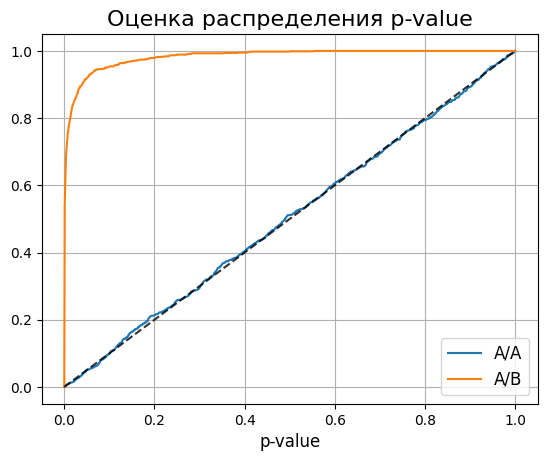

In [7]:
plot_pvalue_distribution({"A/A": pvalues_aa, "A/B": pvalues_ab})

В этот раз мы провели и А/А и А/Б эксперименты. 
    
Дельта-метод контролирует вероятность ошибки первого рода на уровне значимости, когда эффекта нет, и находит эффект, когда он есть.
    
Критерий работает корректно.

### 5. Бакетизация

|bucket 1|bucket 2|...|bucket n|
|---|---|---|---|
|m users|m users|...|m users|
|ctr 1|ctr 2|...|ctr n|

Условия:
- m, n -- достаточно большие
- дисперсия внутри бакетов и между бакетами достаточно низкая

$$\bar{\text{ctr}} \sim^{asy} N(\text{ctr}, ...)$$

Доля ошибок первого рода: 0.04


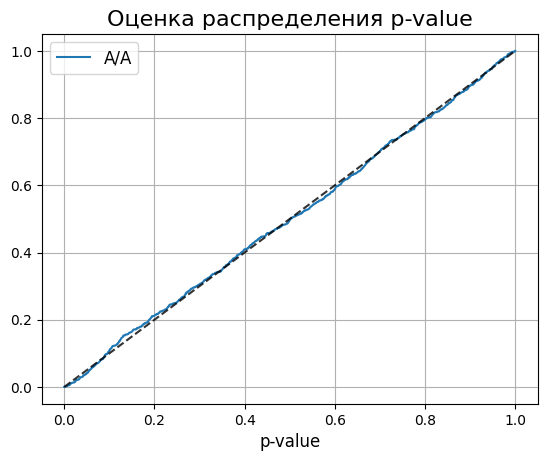

In [58]:
def calc_bucket_metric(group, m):
    n = len(group)
    bucket_metrics = [np.mean(np.concat(group[i : i + m])) for i in range(0, n, m)]
    return bucket_metrics


pvalues = []
for _ in range(1000):
    a, b = generate_data(sample_size, 0)
    a_buckets = calc_bucket_metric(a, m=200)
    b_buckets = calc_bucket_metric(b, m=200)
    pvalue = stats.ttest_ind(a_buckets, b_buckets).pvalue
    pvalues.append(pvalue)


error_rate = np.mean(np.array(pvalues) < alpha)
print(f"Доля ошибок первого рода: {error_rate:0.2f}")
plot_pvalue_distribution({"A/A": pvalues})